In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf

%matplotlib inline
plt.style.use('ggplot')

In [6]:
def read_data(file_path):
    column_names = ['user-id','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
    data = pd.read_csv(file_path,header = None, names = column_names)
    return data

def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma

In [7]:
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


#create
def plot_subject(subject,data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (15, 10), sharex = True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(subject)
    plt.subplots_adjust(top=0.90)
    plt.show()
    
    
def windows(data, size):
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += (size / 2)

def segment_signal(data,window_size = 90):
    segments = np.empty((0,window_size,3))
    labels = np.empty((0))
    for (start, end) in windows(data['timestamp'], window_size):
        x = data["x-axis"][start:end]
        y = data["y-axis"][start:end]
        z = data["z-axis"][start:end]
        if(len(dataset['timestamp'][start:end]) == window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels = np.append(labels,stats.mode(data["user-id"][start:end])[0][0])
    return segments, labels

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape = shape)
    return tf.Variable(initial)

def depthwise_conv2d(x, W):
    return tf.nn.depthwise_conv2d(x,W, [1, 1, 1, 1], padding='VALID')

def apply_depthwise_conv(x,kernel_size,num_channels,depth):
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth * num_channels])
    return tf.nn.relu(tf.add(depthwise_conv2d(x, weights),biases))
    
def apply_max_pool(x,kernel_size,stride_size):
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1], 
                          strides=[1, 1, stride_size, 1], padding='VALID')

In [4]:
dataset = read_data('actitracker_raw2.txt')
dataset = dataset.replace(";","",regex=True)#.replace(';',',')

In [5]:
dataset['x-axis'] = feature_normalize(dataset['x-axis'])
dataset['y-axis'] = feature_normalize(dataset['y-axis'])
dataset['z-axis'] = feature_normalize(dataset['z-axis'])

TypeError: must be str, not int

In [6]:
dataset

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.198203,0.804142,0.50395286
1,33,Jogging,49106062271000,0.635039,0.594170,0.95342433
2,33,Jogging,49106112167000,0.619130,0.537639,-0.08172209
3,33,Jogging,49106222305000,-0.186271,1.666240,3.0237172
4,33,Jogging,49106332290000,-0.269795,0.719346,7.205164
5,33,Jogging,49106442306000,0.104071,-1.444986,-6.510526
6,33,Jogging,49106542312000,-0.186271,0.491202,5.706926
7,33,Jogging,49106652389000,-0.170362,0.991906,7.0553403
8,33,Jogging,49106762313000,-1.327754,0.616378,5.134871
9,33,Jogging,49106872299000,0.042423,-0.871599,1.6480621


TypeError: unsupported operand type(s) for -: 'float' and 'str'

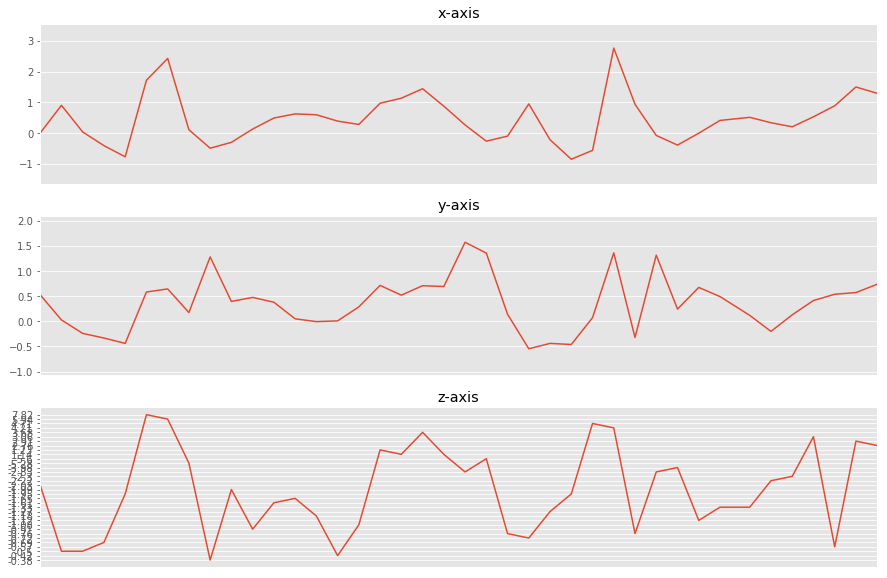

In [7]:
#modify taerget(user-id)
for subject in np.unique(dataset["user-id"]):
    subset = dataset[dataset["user-id"] == subject][:40]
    plot_subject(subject,subset)

In [8]:
segments, labels = segment_signal(dataset)
labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)
reshaped_segments = segments.reshape(len(segments), 1,90, 3)

In [9]:
train_test_split = np.random.rand(len(reshaped_segments)) < 0.70

train_x = reshaped_segments[train_test_split]
train_y = labels[train_test_split]
test_x = reshaped_segments[~train_test_split]
test_y = labels[~train_test_split]

In [1]:
#saved data
np.save('train_x.npy',train_x)
np.save('train_y.npy',train_y)
np.save('test_x.npy',test_x)
np.save('test_y.npy',test_y)

NameError: name 'np' is not defined

In [8]:
import numpy as np
train_x = np.load('train_x.npy')
train_y = np.load('train_y.npy')
test_x = np.load('test_x.npy')
test_y = np.load('test_y.npy')

In [13]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 64
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 300

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.MomentumOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
        with tf.name_scope('summary'):
            tf.summary.scalar('loss', loss)
            merged = tf.summary.merge_all()
            writer = tf.summary.FileWriter('./logs', session.graph)
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

TypeError: __init__() missing 1 required positional argument: 'momentum'

In [10]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 64 #(128)
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 200

total_batches = train_x.shape[0] // batch_size

In [11]:
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

In [12]:
loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [32]:
train_x.shape

(17152, 1, 90, 3)

In [13]:
with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  33.1968  Training Accuracy:  0.0409171
Epoch:  1  Training Loss:  35.6132  Training Accuracy:  0.0409171
Epoch:  2  Training Loss:  37.0849  Training Accuracy:  0.0433862
Epoch:  3  Training Loss:  38.1057  Training Accuracy:  0.0447972
Epoch:  4  Training Loss:  38.8707  Training Accuracy:  0.046796
Epoch:  5  Training Loss:  39.5741  Training Accuracy:  0.0489124
Epoch:  6  Training Loss:  40.1169  Training Accuracy:  0.052087
Epoch:  7  Training Loss:  40.5513  Training Accuracy:  0.0562022
Epoch:  8  Training Loss:  40.8959  Training Accuracy:  0.0589065
Epoch:  9  Training Loss:  41.2386  Training Accuracy:  0.0607878
Epoch:  10  Training Loss:  41.5907  Training Accuracy:  0.0634921
Epoch:  11  Training Loss:  41.8969  Training Accuracy:  0.0676661
Epoch:  12  Training Loss:  42.2046  Training Accuracy:  0.0738977
Epoch:  13  Training Loss:  42.441  Training Accuracy:  0.0813051
Epoch:  14  Training Loss:  42.6838  Training Accuracy:  0.0897119
Epoch:  

Epoch:  125  Training Loss:  54.6478  Training Accuracy:  0.5194
Epoch:  126  Training Loss:  54.5284  Training Accuracy:  0.52087
Epoch:  127  Training Loss:  54.4326  Training Accuracy:  0.522222
Epoch:  128  Training Loss:  54.3429  Training Accuracy:  0.524221
Epoch:  129  Training Loss:  54.2332  Training Accuracy:  0.525808
Epoch:  130  Training Loss:  54.1012  Training Accuracy:  0.527337
Epoch:  131  Training Loss:  53.9912  Training Accuracy:  0.529159
Epoch:  132  Training Loss:  53.866  Training Accuracy:  0.531452
Epoch:  133  Training Loss:  53.7499  Training Accuracy:  0.533862
Epoch:  134  Training Loss:  53.6307  Training Accuracy:  0.536508
Epoch:  135  Training Loss:  53.5146  Training Accuracy:  0.538389
Epoch:  136  Training Loss:  53.4227  Training Accuracy:  0.540035
Epoch:  137  Training Loss:  53.2831  Training Accuracy:  0.541975
Epoch:  138  Training Loss:  53.2082  Training Accuracy:  0.543445
Epoch:  139  Training Loss:  53.0808  Training Accuracy:  0.545209

In [14]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 64 #(128)
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 300

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  33.0511  Training Accuracy:  0.0409759
Epoch:  1  Training Loss:  31.2921  Training Accuracy:  0.0409759
Epoch:  2  Training Loss:  31.1127  Training Accuracy:  0.0421517
Epoch:  3  Training Loss:  31.352  Training Accuracy:  0.0476778
Epoch:  4  Training Loss:  31.6794  Training Accuracy:  0.0546737
Epoch:  5  Training Loss:  32.0976  Training Accuracy:  0.0600235
Epoch:  6  Training Loss:  32.5727  Training Accuracy:  0.0634921
Epoch:  7  Training Loss:  33.2026  Training Accuracy:  0.0683715
Epoch:  8  Training Loss:  33.8316  Training Accuracy:  0.0744856
Epoch:  9  Training Loss:  34.5352  Training Accuracy:  0.0800118
Epoch:  10  Training Loss:  35.0213  Training Accuracy:  0.0858907
Epoch:  11  Training Loss:  35.4852  Training Accuracy:  0.0927102
Epoch:  12  Training Loss:  35.8859  Training Accuracy:  0.09806
Epoch:  13  Training Loss:  36.0901  Training Accuracy:  0.103645
Epoch:  14  Training Loss:  36.2503  Training Accuracy:  0.108172
Epoch:  15

Epoch:  125  Training Loss:  53.0287  Training Accuracy:  0.518871
Epoch:  126  Training Loss:  52.9861  Training Accuracy:  0.520929
Epoch:  127  Training Loss:  52.926  Training Accuracy:  0.523045
Epoch:  128  Training Loss:  52.8907  Training Accuracy:  0.524456
Epoch:  129  Training Loss:  52.868  Training Accuracy:  0.526043
Epoch:  130  Training Loss:  52.8021  Training Accuracy:  0.527631
Epoch:  131  Training Loss:  52.7642  Training Accuracy:  0.530041
Epoch:  132  Training Loss:  52.7428  Training Accuracy:  0.532275
Epoch:  133  Training Loss:  52.6499  Training Accuracy:  0.534744
Epoch:  134  Training Loss:  52.5879  Training Accuracy:  0.536038
Epoch:  135  Training Loss:  52.5524  Training Accuracy:  0.538036
Epoch:  136  Training Loss:  52.5451  Training Accuracy:  0.540506
Epoch:  137  Training Loss:  52.5079  Training Accuracy:  0.542269
Epoch:  138  Training Loss:  52.4948  Training Accuracy:  0.543915
Epoch:  139  Training Loss:  52.4884  Training Accuracy:  0.5458

Epoch:  248  Training Loss:  50.4999  Training Accuracy:  0.716167
Epoch:  249  Training Loss:  50.4028  Training Accuracy:  0.717813
Epoch:  250  Training Loss:  50.3371  Training Accuracy:  0.719342
Epoch:  251  Training Loss:  50.2374  Training Accuracy:  0.72087
Epoch:  252  Training Loss:  50.1468  Training Accuracy:  0.722105
Epoch:  253  Training Loss:  50.059  Training Accuracy:  0.723281
Epoch:  254  Training Loss:  50.0083  Training Accuracy:  0.724574
Epoch:  255  Training Loss:  49.9009  Training Accuracy:  0.725632
Epoch:  256  Training Loss:  49.8435  Training Accuracy:  0.727043
Epoch:  257  Training Loss:  49.7531  Training Accuracy:  0.728219
Epoch:  258  Training Loss:  49.6853  Training Accuracy:  0.728866
Epoch:  259  Training Loss:  49.6074  Training Accuracy:  0.730276
Epoch:  260  Training Loss:  49.5498  Training Accuracy:  0.731452
Epoch:  261  Training Loss:  49.4606  Training Accuracy:  0.732687
Epoch:  262  Training Loss:  49.4022  Training Accuracy:  0.7335

In [15]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 64 #(128)
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 400

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  162.126  Training Accuracy:  0.0435038
Epoch:  1  Training Loss:  179.855  Training Accuracy:  0.0493239
Epoch:  2  Training Loss:  189.472  Training Accuracy:  0.0627866
Epoch:  3  Training Loss:  194.607  Training Accuracy:  0.0793063
Epoch:  4  Training Loss:  198.018  Training Accuracy:  0.0917108
Epoch:  5  Training Loss:  200.349  Training Accuracy:  0.100999
Epoch:  6  Training Loss:  201.925  Training Accuracy:  0.109465
Epoch:  7  Training Loss:  202.946  Training Accuracy:  0.121046
Epoch:  8  Training Loss:  203.642  Training Accuracy:  0.132863
Epoch:  9  Training Loss:  204.072  Training Accuracy:  0.143151
Epoch:  10  Training Loss:  204.317  Training Accuracy:  0.153792
Epoch:  11  Training Loss:  204.423  Training Accuracy:  0.165021
Epoch:  12  Training Loss:  204.41  Training Accuracy:  0.17378
Epoch:  13  Training Loss:  204.314  Training Accuracy:  0.180482
Epoch:  14  Training Loss:  204.165  Training Accuracy:  0.186537
Epoch:  15  Train

Epoch:  125  Training Loss:  178.343  Training Accuracy:  0.547795
Epoch:  126  Training Loss:  178.304  Training Accuracy:  0.550206
Epoch:  127  Training Loss:  178.224  Training Accuracy:  0.552087
Epoch:  128  Training Loss:  178.179  Training Accuracy:  0.553851
Epoch:  129  Training Loss:  178.092  Training Accuracy:  0.55632
Epoch:  130  Training Loss:  178.045  Training Accuracy:  0.557437
Epoch:  131  Training Loss:  177.975  Training Accuracy:  0.559377
Epoch:  132  Training Loss:  177.92  Training Accuracy:  0.561611
Epoch:  133  Training Loss:  177.853  Training Accuracy:  0.562845
Epoch:  134  Training Loss:  177.792  Training Accuracy:  0.564668
Epoch:  135  Training Loss:  177.722  Training Accuracy:  0.56649
Epoch:  136  Training Loss:  177.647  Training Accuracy:  0.568548
Epoch:  137  Training Loss:  177.609  Training Accuracy:  0.570076
Epoch:  138  Training Loss:  177.521  Training Accuracy:  0.572193
Epoch:  139  Training Loss:  177.455  Training Accuracy:  0.57448

Epoch:  248  Training Loss:  172.218  Training Accuracy:  0.698354
Epoch:  249  Training Loss:  172.147  Training Accuracy:  0.699177
Epoch:  250  Training Loss:  172.125  Training Accuracy:  0.699589
Epoch:  251  Training Loss:  172.07  Training Accuracy:  0.700353
Epoch:  252  Training Loss:  172.003  Training Accuracy:  0.701235
Epoch:  253  Training Loss:  171.936  Training Accuracy:  0.702175
Epoch:  254  Training Loss:  171.886  Training Accuracy:  0.702763
Epoch:  255  Training Loss:  171.814  Training Accuracy:  0.703469
Epoch:  256  Training Loss:  171.781  Training Accuracy:  0.704292
Epoch:  257  Training Loss:  171.75  Training Accuracy:  0.704821
Epoch:  258  Training Loss:  171.653  Training Accuracy:  0.705291
Epoch:  259  Training Loss:  171.619  Training Accuracy:  0.705938
Epoch:  260  Training Loss:  171.528  Training Accuracy:  0.706467
Epoch:  261  Training Loss:  171.491  Training Accuracy:  0.707584
Epoch:  262  Training Loss:  171.415  Training Accuracy:  0.7082

Epoch:  371  Training Loss:  160.634  Training Accuracy:  0.770841
Epoch:  372  Training Loss:  160.5  Training Accuracy:  0.771546
Epoch:  373  Training Loss:  160.423  Training Accuracy:  0.772134
Epoch:  374  Training Loss:  160.233  Training Accuracy:  0.772428
Epoch:  375  Training Loss:  160.127  Training Accuracy:  0.772899
Epoch:  376  Training Loss:  159.923  Training Accuracy:  0.773428
Epoch:  377  Training Loss:  159.671  Training Accuracy:  0.774133
Epoch:  378  Training Loss:  159.652  Training Accuracy:  0.774839
Epoch:  379  Training Loss:  159.513  Training Accuracy:  0.77525
Epoch:  380  Training Loss:  159.317  Training Accuracy:  0.775662
Epoch:  381  Training Loss:  159.181  Training Accuracy:  0.776367
Epoch:  382  Training Loss:  159.011  Training Accuracy:  0.776661
Epoch:  383  Training Loss:  158.87  Training Accuracy:  0.777425
Epoch:  384  Training Loss:  158.8  Training Accuracy:  0.77766
Epoch:  385  Training Loss:  158.575  Training Accuracy:  0.778542
Ep

In [16]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 64 #(128)
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 500

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  32.7082  Training Accuracy:  0.0409171
Epoch:  1  Training Loss:  28.506  Training Accuracy:  0.0409759
Epoch:  2  Training Loss:  27.5811  Training Accuracy:  0.0423868
Epoch:  3  Training Loss:  27.9487  Training Accuracy:  0.0482069
Epoch:  4  Training Loss:  28.2934  Training Accuracy:  0.0531452
Epoch:  5  Training Loss:  28.5934  Training Accuracy:  0.0579071
Epoch:  6  Training Loss:  28.9419  Training Accuracy:  0.0613757
Epoch:  7  Training Loss:  29.326  Training Accuracy:  0.0641387
Epoch:  8  Training Loss:  29.6398  Training Accuracy:  0.0674309
Epoch:  9  Training Loss:  29.8456  Training Accuracy:  0.0708407
Epoch:  10  Training Loss:  30.0088  Training Accuracy:  0.0742504
Epoch:  11  Training Loss:  30.1933  Training Accuracy:  0.0788948
Epoch:  12  Training Loss:  30.3296  Training Accuracy:  0.0837742
Epoch:  13  Training Loss:  30.5384  Training Accuracy:  0.0881246
Epoch:  14  Training Loss:  30.7825  Training Accuracy:  0.0931217
Epoch: 

Epoch:  125  Training Loss:  59.461  Training Accuracy:  0.515226
Epoch:  126  Training Loss:  59.442  Training Accuracy:  0.517401
Epoch:  127  Training Loss:  59.376  Training Accuracy:  0.519753
Epoch:  128  Training Loss:  59.3638  Training Accuracy:  0.521693
Epoch:  129  Training Loss:  59.2831  Training Accuracy:  0.523751
Epoch:  130  Training Loss:  59.2758  Training Accuracy:  0.525103
Epoch:  131  Training Loss:  59.1384  Training Accuracy:  0.527043
Epoch:  132  Training Loss:  59.1481  Training Accuracy:  0.528748
Epoch:  133  Training Loss:  59.0565  Training Accuracy:  0.530394
Epoch:  134  Training Loss:  59.0168  Training Accuracy:  0.532863
Epoch:  135  Training Loss:  58.9062  Training Accuracy:  0.534568
Epoch:  136  Training Loss:  58.8714  Training Accuracy:  0.535979
Epoch:  137  Training Loss:  58.8074  Training Accuracy:  0.537625
Epoch:  138  Training Loss:  58.7775  Training Accuracy:  0.539095
Epoch:  139  Training Loss:  58.7052  Training Accuracy:  0.54138

Epoch:  248  Training Loss:  53.2594  Training Accuracy:  0.706467
Epoch:  249  Training Loss:  53.2041  Training Accuracy:  0.70729
Epoch:  250  Training Loss:  53.1179  Training Accuracy:  0.708466
Epoch:  251  Training Loss:  53.2045  Training Accuracy:  0.709994
Epoch:  252  Training Loss:  53.1018  Training Accuracy:  0.711405
Epoch:  253  Training Loss:  53.1156  Training Accuracy:  0.712287
Epoch:  254  Training Loss:  52.9894  Training Accuracy:  0.713404
Epoch:  255  Training Loss:  53.0949  Training Accuracy:  0.714286
Epoch:  256  Training Loss:  52.9864  Training Accuracy:  0.715932
Epoch:  257  Training Loss:  53.003  Training Accuracy:  0.717637
Epoch:  258  Training Loss:  52.9662  Training Accuracy:  0.718519
Epoch:  259  Training Loss:  52.9738  Training Accuracy:  0.719636
Epoch:  260  Training Loss:  52.9084  Training Accuracy:  0.720753
Epoch:  261  Training Loss:  52.8822  Training Accuracy:  0.721928
Epoch:  262  Training Loss:  52.8231  Training Accuracy:  0.7230

Epoch:  371  Training Loss:  49.6706  Training Accuracy:  0.822105
Epoch:  372  Training Loss:  49.642  Training Accuracy:  0.822693
Epoch:  373  Training Loss:  49.6521  Training Accuracy:  0.823222
Epoch:  374  Training Loss:  49.5958  Training Accuracy:  0.824104
Epoch:  375  Training Loss:  49.5559  Training Accuracy:  0.825338
Epoch:  376  Training Loss:  49.4912  Training Accuracy:  0.825574
Epoch:  377  Training Loss:  49.5516  Training Accuracy:  0.826103
Epoch:  378  Training Loss:  49.5041  Training Accuracy:  0.826749
Epoch:  379  Training Loss:  49.5543  Training Accuracy:  0.827514
Epoch:  380  Training Loss:  49.5001  Training Accuracy:  0.828101
Epoch:  381  Training Loss:  49.4603  Training Accuracy:  0.828983
Epoch:  382  Training Loss:  49.4168  Training Accuracy:  0.829571
Epoch:  383  Training Loss:  49.4382  Training Accuracy:  0.830394
Epoch:  384  Training Loss:  49.3717  Training Accuracy:  0.830571
Epoch:  385  Training Loss:  49.438  Training Accuracy:  0.8312

Epoch:  494  Training Loss:  46.3554  Training Accuracy:  0.88301
Epoch:  495  Training Loss:  46.2821  Training Accuracy:  0.883657
Epoch:  496  Training Loss:  46.1896  Training Accuracy:  0.88354
Epoch:  497  Training Loss:  46.1408  Training Accuracy:  0.884245
Epoch:  498  Training Loss:  46.008  Training Accuracy:  0.884186
Epoch:  499  Training Loss:  45.9296  Training Accuracy:  0.884892
Testing Accuracy: 0.80698


In [17]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 128
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 200

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  14.6381  Training Accuracy:  0.0408583
Epoch:  1  Training Loss:  23.345  Training Accuracy:  0.0430923
Epoch:  2  Training Loss:  27.1044  Training Accuracy:  0.0495591
Epoch:  3  Training Loss:  30.681  Training Accuracy:  0.0537331
Epoch:  4  Training Loss:  34.3444  Training Accuracy:  0.0568489
Epoch:  5  Training Loss:  36.8187  Training Accuracy:  0.060435
Epoch:  6  Training Loss:  38.8072  Training Accuracy:  0.0659612
Epoch:  7  Training Loss:  40.4415  Training Accuracy:  0.0717225
Epoch:  8  Training Loss:  41.6326  Training Accuracy:  0.0801293
Epoch:  9  Training Loss:  42.7347  Training Accuracy:  0.0920635
Epoch:  10  Training Loss:  43.4051  Training Accuracy:  0.10341
Epoch:  11  Training Loss:  43.8378  Training Accuracy:  0.113933
Epoch:  12  Training Loss:  44.5414  Training Accuracy:  0.124633
Epoch:  13  Training Loss:  45.213  Training Accuracy:  0.133392
Epoch:  14  Training Loss:  45.9662  Training Accuracy:  0.141917
Epoch:  15  Tra

Epoch:  125  Training Loss:  91.1473  Training Accuracy:  0.567196
Epoch:  126  Training Loss:  90.9861  Training Accuracy:  0.568783
Epoch:  127  Training Loss:  91.0841  Training Accuracy:  0.570782
Epoch:  128  Training Loss:  90.9053  Training Accuracy:  0.572781
Epoch:  129  Training Loss:  90.9653  Training Accuracy:  0.57478
Epoch:  130  Training Loss:  90.7914  Training Accuracy:  0.577484
Epoch:  131  Training Loss:  90.9113  Training Accuracy:  0.579071
Epoch:  132  Training Loss:  90.7377  Training Accuracy:  0.58107
Epoch:  133  Training Loss:  90.8099  Training Accuracy:  0.583069
Epoch:  134  Training Loss:  90.6028  Training Accuracy:  0.585949
Epoch:  135  Training Loss:  90.7745  Training Accuracy:  0.587654
Epoch:  136  Training Loss:  90.565  Training Accuracy:  0.5893
Epoch:  137  Training Loss:  90.641  Training Accuracy:  0.590711
Epoch:  138  Training Loss:  90.4961  Training Accuracy:  0.592299
Epoch:  139  Training Loss:  90.5873  Training Accuracy:  0.593651
E

In [18]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 128
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 300

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  39.1417  Training Accuracy:  0.0391534
Epoch:  1  Training Loss:  47.0061  Training Accuracy:  0.0466784
Epoch:  2  Training Loss:  54.4406  Training Accuracy:  0.0470312
Epoch:  3  Training Loss:  60.8398  Training Accuracy:  0.050147
Epoch:  4  Training Loss:  67.7658  Training Accuracy:  0.0535567
Epoch:  5  Training Loss:  73.8586  Training Accuracy:  0.0569665
Epoch:  6  Training Loss:  78.777  Training Accuracy:  0.0610229
Epoch:  7  Training Loss:  80.8754  Training Accuracy:  0.0638448
Epoch:  8  Training Loss:  82.6952  Training Accuracy:  0.0674897
Epoch:  9  Training Loss:  84.4109  Training Accuracy:  0.0707231
Epoch:  10  Training Loss:  83.7744  Training Accuracy:  0.0756026
Epoch:  11  Training Loss:  83.4048  Training Accuracy:  0.0813051
Epoch:  12  Training Loss:  83.1021  Training Accuracy:  0.0870076
Epoch:  13  Training Loss:  81.3249  Training Accuracy:  0.0929453
Epoch:  14  Training Loss:  79.4958  Training Accuracy:  0.100176
Epoch:  

Epoch:  125  Training Loss:  60.9481  Training Accuracy:  0.573369
Epoch:  126  Training Loss:  60.9062  Training Accuracy:  0.576249
Epoch:  127  Training Loss:  60.9466  Training Accuracy:  0.57866
Epoch:  128  Training Loss:  60.9587  Training Accuracy:  0.580423
Epoch:  129  Training Loss:  60.9996  Training Accuracy:  0.582304
Epoch:  130  Training Loss:  61.072  Training Accuracy:  0.583892
Epoch:  131  Training Loss:  61.1072  Training Accuracy:  0.585597
Epoch:  132  Training Loss:  61.2107  Training Accuracy:  0.587066
Epoch:  133  Training Loss:  61.2475  Training Accuracy:  0.588654
Epoch:  134  Training Loss:  61.3411  Training Accuracy:  0.58983
Epoch:  135  Training Loss:  61.424  Training Accuracy:  0.59124
Epoch:  136  Training Loss:  61.5192  Training Accuracy:  0.592593
Epoch:  137  Training Loss:  61.6406  Training Accuracy:  0.594885
Epoch:  138  Training Loss:  61.7887  Training Accuracy:  0.596237
Epoch:  139  Training Loss:  61.9492  Training Accuracy:  0.59806
E

Epoch:  248  Training Loss:  77.7314  Training Accuracy:  0.756261
Epoch:  249  Training Loss:  77.3733  Training Accuracy:  0.757319
Epoch:  250  Training Loss:  77.6209  Training Accuracy:  0.758143
Epoch:  251  Training Loss:  77.2558  Training Accuracy:  0.759318
Epoch:  252  Training Loss:  77.3951  Training Accuracy:  0.760141
Epoch:  253  Training Loss:  77.4804  Training Accuracy:  0.760964
Epoch:  254  Training Loss:  77.0626  Training Accuracy:  0.762199
Epoch:  255  Training Loss:  77.2348  Training Accuracy:  0.763434
Epoch:  256  Training Loss:  76.8398  Training Accuracy:  0.764492
Epoch:  257  Training Loss:  76.8865  Training Accuracy:  0.765138
Epoch:  258  Training Loss:  76.9728  Training Accuracy:  0.765785
Epoch:  259  Training Loss:  76.5207  Training Accuracy:  0.767314
Epoch:  260  Training Loss:  76.6211  Training Accuracy:  0.768078
Epoch:  261  Training Loss:  76.5101  Training Accuracy:  0.769195
Epoch:  262  Training Loss:  76.1513  Training Accuracy:  0.76

In [19]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 128
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 400

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  17.9125  Training Accuracy:  0.0409759
Epoch:  1  Training Loss:  31.2156  Training Accuracy:  0.0410347
Epoch:  2  Training Loss:  41.4486  Training Accuracy:  0.0414462
Epoch:  3  Training Loss:  52.2145  Training Accuracy:  0.0442681
Epoch:  4  Training Loss:  58.19  Training Accuracy:  0.0496179
Epoch:  5  Training Loss:  62.3194  Training Accuracy:  0.0579071
Epoch:  6  Training Loss:  66.1681  Training Accuracy:  0.0662551
Epoch:  7  Training Loss:  68.3259  Training Accuracy:  0.0725456
Epoch:  8  Training Loss:  68.2633  Training Accuracy:  0.0779541
Epoch:  9  Training Loss:  69.3013  Training Accuracy:  0.0845973
Epoch:  10  Training Loss:  70.3947  Training Accuracy:  0.0898883
Epoch:  11  Training Loss:  70.8521  Training Accuracy:  0.0948266
Epoch:  12  Training Loss:  71.5679  Training Accuracy:  0.099177
Epoch:  13  Training Loss:  72.1913  Training Accuracy:  0.107113
Epoch:  14  Training Loss:  73.014  Training Accuracy:  0.115873
Epoch:  15 

Epoch:  125  Training Loss:  64.0653  Training Accuracy:  0.572957
Epoch:  126  Training Loss:  64.2297  Training Accuracy:  0.574721
Epoch:  127  Training Loss:  64.4254  Training Accuracy:  0.576661
Epoch:  128  Training Loss:  64.5516  Training Accuracy:  0.578601
Epoch:  129  Training Loss:  64.7123  Training Accuracy:  0.580129
Epoch:  130  Training Loss:  64.8421  Training Accuracy:  0.581775
Epoch:  131  Training Loss:  64.966  Training Accuracy:  0.583833
Epoch:  132  Training Loss:  65.1022  Training Accuracy:  0.585126
Epoch:  133  Training Loss:  65.2839  Training Accuracy:  0.587066
Epoch:  134  Training Loss:  65.3086  Training Accuracy:  0.588948
Epoch:  135  Training Loss:  65.4705  Training Accuracy:  0.5903
Epoch:  136  Training Loss:  65.5642  Training Accuracy:  0.592063
Epoch:  137  Training Loss:  65.7154  Training Accuracy:  0.592945
Epoch:  138  Training Loss:  65.9317  Training Accuracy:  0.594709
Epoch:  139  Training Loss:  66.0983  Training Accuracy:  0.59617

Epoch:  248  Training Loss:  77.8139  Training Accuracy:  0.75003
Epoch:  249  Training Loss:  77.7547  Training Accuracy:  0.750794
Epoch:  250  Training Loss:  77.652  Training Accuracy:  0.751617
Epoch:  251  Training Loss:  77.5966  Training Accuracy:  0.752851
Epoch:  252  Training Loss:  77.471  Training Accuracy:  0.754204
Epoch:  253  Training Loss:  77.401  Training Accuracy:  0.755144
Epoch:  254  Training Loss:  77.295  Training Accuracy:  0.75585
Epoch:  255  Training Loss:  77.2504  Training Accuracy:  0.756555
Epoch:  256  Training Loss:  77.1261  Training Accuracy:  0.757437
Epoch:  257  Training Loss:  77.0376  Training Accuracy:  0.757966
Epoch:  258  Training Loss:  76.9485  Training Accuracy:  0.758848
Epoch:  259  Training Loss:  76.8285  Training Accuracy:  0.759495
Epoch:  260  Training Loss:  76.6745  Training Accuracy:  0.760083
Epoch:  261  Training Loss:  76.5881  Training Accuracy:  0.7612
Epoch:  262  Training Loss:  76.4125  Training Accuracy:  0.761611
Epo

Epoch:  371  Training Loss:  55.9267  Training Accuracy:  0.846032
Epoch:  372  Training Loss:  55.7344  Training Accuracy:  0.846796
Epoch:  373  Training Loss:  55.6186  Training Accuracy:  0.847384
Epoch:  374  Training Loss:  55.4049  Training Accuracy:  0.848031
Epoch:  375  Training Loss:  55.2584  Training Accuracy:  0.848325
Epoch:  376  Training Loss:  55.0782  Training Accuracy:  0.848795
Epoch:  377  Training Loss:  54.9336  Training Accuracy:  0.849148
Epoch:  378  Training Loss:  54.7515  Training Accuracy:  0.849501
Epoch:  379  Training Loss:  54.5762  Training Accuracy:  0.850383
Epoch:  380  Training Loss:  54.4206  Training Accuracy:  0.850853
Epoch:  381  Training Loss:  54.2727  Training Accuracy:  0.851323
Epoch:  382  Training Loss:  54.0888  Training Accuracy:  0.851793
Epoch:  383  Training Loss:  53.9237  Training Accuracy:  0.852264
Epoch:  384  Training Loss:  53.7591  Training Accuracy:  0.852616
Epoch:  385  Training Loss:  53.6059  Training Accuracy:  0.85

In [20]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 128
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 500

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  65.2185  Training Accuracy:  0.0393886
Epoch:  1  Training Loss:  42.5247  Training Accuracy:  0.0393886
Epoch:  2  Training Loss:  45.5513  Training Accuracy:  0.0429747
Epoch:  3  Training Loss:  49.4864  Training Accuracy:  0.0444444
Epoch:  4  Training Loss:  52.2846  Training Accuracy:  0.045973
Epoch:  5  Training Loss:  54.6056  Training Accuracy:  0.047619
Epoch:  6  Training Loss:  55.3263  Training Accuracy:  0.0503233
Epoch:  7  Training Loss:  55.9798  Training Accuracy:  0.0538507
Epoch:  8  Training Loss:  56.7656  Training Accuracy:  0.0587889
Epoch:  9  Training Loss:  56.7429  Training Accuracy:  0.0625514
Epoch:  10  Training Loss:  57.0772  Training Accuracy:  0.0688419
Epoch:  11  Training Loss:  57.0337  Training Accuracy:  0.0733098
Epoch:  12  Training Loss:  56.6778  Training Accuracy:  0.0783069
Epoch:  13  Training Loss:  56.1767  Training Accuracy:  0.0834215
Epoch:  14  Training Loss:  55.6762  Training Accuracy:  0.0911229
Epoch: 

Epoch:  125  Training Loss:  65.8169  Training Accuracy:  0.562022
Epoch:  126  Training Loss:  66.0055  Training Accuracy:  0.564315
Epoch:  127  Training Loss:  66.2191  Training Accuracy:  0.56649
Epoch:  128  Training Loss:  66.3996  Training Accuracy:  0.568019
Epoch:  129  Training Loss:  66.55  Training Accuracy:  0.570135
Epoch:  130  Training Loss:  66.7354  Training Accuracy:  0.571252
Epoch:  131  Training Loss:  66.9212  Training Accuracy:  0.573016
Epoch:  132  Training Loss:  67.1221  Training Accuracy:  0.575191
Epoch:  133  Training Loss:  67.3388  Training Accuracy:  0.576367
Epoch:  134  Training Loss:  67.5796  Training Accuracy:  0.578189
Epoch:  135  Training Loss:  67.7609  Training Accuracy:  0.580541
Epoch:  136  Training Loss:  67.9946  Training Accuracy:  0.582128
Epoch:  137  Training Loss:  68.1877  Training Accuracy:  0.583186
Epoch:  138  Training Loss:  68.4262  Training Accuracy:  0.585773
Epoch:  139  Training Loss:  68.607  Training Accuracy:  0.58736


Epoch:  248  Training Loss:  79.3849  Training Accuracy:  0.738801
Epoch:  249  Training Loss:  79.3323  Training Accuracy:  0.739918
Epoch:  250  Training Loss:  79.2605  Training Accuracy:  0.741094
Epoch:  251  Training Loss:  79.2302  Training Accuracy:  0.742093
Epoch:  252  Training Loss:  79.1755  Training Accuracy:  0.742799
Epoch:  253  Training Loss:  79.1218  Training Accuracy:  0.743798
Epoch:  254  Training Loss:  79.1087  Training Accuracy:  0.744856
Epoch:  255  Training Loss:  79.0598  Training Accuracy:  0.745679
Epoch:  256  Training Loss:  78.9959  Training Accuracy:  0.74662
Epoch:  257  Training Loss:  78.9228  Training Accuracy:  0.747737
Epoch:  258  Training Loss:  78.8654  Training Accuracy:  0.748795
Epoch:  259  Training Loss:  78.7912  Training Accuracy:  0.749677
Epoch:  260  Training Loss:  78.7209  Training Accuracy:  0.750676
Epoch:  261  Training Loss:  78.6637  Training Accuracy:  0.751441
Epoch:  262  Training Loss:  78.5997  Training Accuracy:  0.751

Epoch:  371  Training Loss:  57.2533  Training Accuracy:  0.840682
Epoch:  372  Training Loss:  56.9899  Training Accuracy:  0.840976
Epoch:  373  Training Loss:  56.7807  Training Accuracy:  0.841388
Epoch:  374  Training Loss:  56.4752  Training Accuracy:  0.841917
Epoch:  375  Training Loss:  56.3193  Training Accuracy:  0.84227
Epoch:  376  Training Loss:  56.0929  Training Accuracy:  0.842622
Epoch:  377  Training Loss:  55.8326  Training Accuracy:  0.84321
Epoch:  378  Training Loss:  55.6409  Training Accuracy:  0.843504
Epoch:  379  Training Loss:  55.3799  Training Accuracy:  0.843857
Epoch:  380  Training Loss:  55.175  Training Accuracy:  0.844562
Epoch:  381  Training Loss:  54.8655  Training Accuracy:  0.845209
Epoch:  382  Training Loss:  54.7099  Training Accuracy:  0.845503
Epoch:  383  Training Loss:  54.4977  Training Accuracy:  0.845915
Epoch:  384  Training Loss:  54.1896  Training Accuracy:  0.846502
Epoch:  385  Training Loss:  54.0358  Training Accuracy:  0.84714

Epoch:  494  Training Loss:  33.7555  Training Accuracy:  0.891006
Epoch:  495  Training Loss:  33.6385  Training Accuracy:  0.891652
Epoch:  496  Training Loss:  33.4937  Training Accuracy:  0.892064
Epoch:  497  Training Loss:  33.2549  Training Accuracy:  0.892711
Epoch:  498  Training Loss:  33.1754  Training Accuracy:  0.893063
Epoch:  499  Training Loss:  33.0073  Training Accuracy:  0.893592
Testing Accuracy: 0.816719


In [21]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 128
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 600

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  32.2218  Training Accuracy:  0.0400353
Epoch:  1  Training Loss:  37.5637  Training Accuracy:  0.0389183
Epoch:  2  Training Loss:  40.4896  Training Accuracy:  0.0402116
Epoch:  3  Training Loss:  47.2207  Training Accuracy:  0.0464433
Epoch:  4  Training Loss:  53.4705  Training Accuracy:  0.0513815
Epoch:  5  Training Loss:  58.6604  Training Accuracy:  0.0567313
Epoch:  6  Training Loss:  63.0149  Training Accuracy:  0.0622575
Epoch:  7  Training Loss:  64.3488  Training Accuracy:  0.0673721
Epoch:  8  Training Loss:  65.0686  Training Accuracy:  0.0711934
Epoch:  9  Training Loss:  66.0268  Training Accuracy:  0.0759553
Epoch:  10  Training Loss:  67.3553  Training Accuracy:  0.081893
Epoch:  11  Training Loss:  67.9285  Training Accuracy:  0.0878895
Epoch:  12  Training Loss:  68.0664  Training Accuracy:  0.0938272
Epoch:  13  Training Loss:  68.2146  Training Accuracy:  0.0997648
Epoch:  14  Training Loss:  68.3915  Training Accuracy:  0.10682
Epoch:  

Epoch:  125  Training Loss:  72.5344  Training Accuracy:  0.56261
Epoch:  126  Training Loss:  72.7922  Training Accuracy:  0.565256
Epoch:  127  Training Loss:  73.0005  Training Accuracy:  0.567137
Epoch:  128  Training Loss:  73.1991  Training Accuracy:  0.569253
Epoch:  129  Training Loss:  73.3753  Training Accuracy:  0.571135
Epoch:  130  Training Loss:  73.553  Training Accuracy:  0.572839
Epoch:  131  Training Loss:  73.7402  Training Accuracy:  0.575015
Epoch:  132  Training Loss:  73.8427  Training Accuracy:  0.576837
Epoch:  133  Training Loss:  73.9527  Training Accuracy:  0.578542
Epoch:  134  Training Loss:  74.051  Training Accuracy:  0.579894
Epoch:  135  Training Loss:  74.2228  Training Accuracy:  0.581775
Epoch:  136  Training Loss:  74.3039  Training Accuracy:  0.583539
Epoch:  137  Training Loss:  74.3848  Training Accuracy:  0.585185
Epoch:  138  Training Loss:  74.4707  Training Accuracy:  0.58689
Epoch:  139  Training Loss:  74.6277  Training Accuracy:  0.589653

Epoch:  248  Training Loss:  69.451  Training Accuracy:  0.750618
Epoch:  249  Training Loss:  69.6461  Training Accuracy:  0.751911
Epoch:  250  Training Loss:  69.2156  Training Accuracy:  0.75244
Epoch:  251  Training Loss:  69.3186  Training Accuracy:  0.753263
Epoch:  252  Training Loss:  68.9731  Training Accuracy:  0.754615
Epoch:  253  Training Loss:  69.0317  Training Accuracy:  0.755321
Epoch:  254  Training Loss:  68.7254  Training Accuracy:  0.75632
Epoch:  255  Training Loss:  68.7795  Training Accuracy:  0.757907
Epoch:  256  Training Loss:  68.4769  Training Accuracy:  0.758789
Epoch:  257  Training Loss:  68.5575  Training Accuracy:  0.760259
Epoch:  258  Training Loss:  68.2534  Training Accuracy:  0.760964
Epoch:  259  Training Loss:  68.3123  Training Accuracy:  0.761964
Epoch:  260  Training Loss:  68.1177  Training Accuracy:  0.762728
Epoch:  261  Training Loss:  67.891  Training Accuracy:  0.76361
Epoch:  262  Training Loss:  67.8267  Training Accuracy:  0.764844


Epoch:  371  Training Loss:  50.2272  Training Accuracy:  0.847267
Epoch:  372  Training Loss:  50.0529  Training Accuracy:  0.847913
Epoch:  373  Training Loss:  49.705  Training Accuracy:  0.848442
Epoch:  374  Training Loss:  49.4019  Training Accuracy:  0.84903
Epoch:  375  Training Loss:  49.2894  Training Accuracy:  0.849501
Epoch:  376  Training Loss:  49.4054  Training Accuracy:  0.849795
Epoch:  377  Training Loss:  48.9747  Training Accuracy:  0.850559
Epoch:  378  Training Loss:  49.0245  Training Accuracy:  0.851088
Epoch:  379  Training Loss:  48.9627  Training Accuracy:  0.851441
Epoch:  380  Training Loss:  48.4013  Training Accuracy:  0.852205
Epoch:  381  Training Loss:  48.0657  Training Accuracy:  0.853028
Epoch:  382  Training Loss:  48.2255  Training Accuracy:  0.853087
Epoch:  383  Training Loss:  47.6875  Training Accuracy:  0.854145
Epoch:  384  Training Loss:  47.8778  Training Accuracy:  0.854321
Epoch:  385  Training Loss:  47.3221  Training Accuracy:  0.8554

Epoch:  494  Training Loss:  27.8155  Training Accuracy:  0.896179
Epoch:  495  Training Loss:  27.6149  Training Accuracy:  0.896473
Epoch:  496  Training Loss:  27.3414  Training Accuracy:  0.897061
Epoch:  497  Training Loss:  27.3676  Training Accuracy:  0.897237
Epoch:  498  Training Loss:  27.2555  Training Accuracy:  0.897355
Epoch:  499  Training Loss:  27.0859  Training Accuracy:  0.897649
Epoch:  500  Training Loss:  26.9759  Training Accuracy:  0.898119
Epoch:  501  Training Loss:  26.7992  Training Accuracy:  0.898354
Epoch:  502  Training Loss:  26.6066  Training Accuracy:  0.898707
Epoch:  503  Training Loss:  26.4227  Training Accuracy:  0.899177
Epoch:  504  Training Loss:  26.2823  Training Accuracy:  0.89953
Epoch:  505  Training Loss:  26.0864  Training Accuracy:  0.899883
Epoch:  506  Training Loss:  25.8466  Training Accuracy:  0.9
Epoch:  507  Training Loss:  25.8447  Training Accuracy:  0.900236
Epoch:  508  Training Loss:  25.7534  Training Accuracy:  0.900471
E

In [43]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 64
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 1000

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  406.32  Training Accuracy:  0.0409865
Epoch:  1  Training Loss:  351.361  Training Accuracy:  0.0421525
Epoch:  2  Training Loss:  324.969  Training Accuracy:  0.0430854
Epoch:  3  Training Loss:  308.678  Training Accuracy:  0.0486241
Epoch:  4  Training Loss:  296.975  Training Accuracy:  0.0571945
Epoch:  5  Training Loss:  288.892  Training Accuracy:  0.0624417
Epoch:  6  Training Loss:  282.659  Training Accuracy:  0.0680387
Epoch:  7  Training Loss:  277.205  Training Accuracy:  0.0735774
Epoch:  8  Training Loss:  272.355  Training Accuracy:  0.0780084
Epoch:  9  Training Loss:  268.178  Training Accuracy:  0.0811567
Epoch:  10  Training Loss:  264.245  Training Accuracy:  0.0858792
Epoch:  11  Training Loss:  260.81  Training Accuracy:  0.0915345
Epoch:  12  Training Loss:  257.501  Training Accuracy:  0.0979478
Epoch:  13  Training Loss:  254.102  Training Accuracy:  0.104594
Epoch:  14  Training Loss:  250.879  Training Accuracy:  0.111765
Epoch:  1

Epoch:  125  Training Loss:  55.086  Training Accuracy:  0.530783
Epoch:  126  Training Loss:  54.4521  Training Accuracy:  0.532124
Epoch:  127  Training Loss:  53.7637  Training Accuracy:  0.533873
Epoch:  128  Training Loss:  53.1214  Training Accuracy:  0.535448
Epoch:  129  Training Loss:  52.4772  Training Accuracy:  0.536847
Epoch:  130  Training Loss:  51.8728  Training Accuracy:  0.538363
Epoch:  131  Training Loss:  51.2478  Training Accuracy:  0.540228
Epoch:  132  Training Loss:  50.6164  Training Accuracy:  0.541394
Epoch:  133  Training Loss:  50.0509  Training Accuracy:  0.542794
Epoch:  134  Training Loss:  49.431  Training Accuracy:  0.544601
Epoch:  135  Training Loss:  48.903  Training Accuracy:  0.546233
Epoch:  136  Training Loss:  48.3299  Training Accuracy:  0.548041
Epoch:  137  Training Loss:  47.7674  Training Accuracy:  0.550373
Epoch:  138  Training Loss:  47.2029  Training Accuracy:  0.552472
Epoch:  139  Training Loss:  46.7154  Training Accuracy:  0.55398

Epoch:  248  Training Loss:  20.5028  Training Accuracy:  0.714085
Epoch:  249  Training Loss:  20.3803  Training Accuracy:  0.714785
Epoch:  250  Training Loss:  20.2621  Training Accuracy:  0.715893
Epoch:  251  Training Loss:  20.1589  Training Accuracy:  0.716884
Epoch:  252  Training Loss:  20.0295  Training Accuracy:  0.718342
Epoch:  253  Training Loss:  19.9296  Training Accuracy:  0.719916
Epoch:  254  Training Loss:  19.7958  Training Accuracy:  0.721315
Epoch:  255  Training Loss:  19.7052  Training Accuracy:  0.722772
Epoch:  256  Training Loss:  19.6015  Training Accuracy:  0.724347
Epoch:  257  Training Loss:  19.4857  Training Accuracy:  0.725221
Epoch:  258  Training Loss:  19.3742  Training Accuracy:  0.726737
Epoch:  259  Training Loss:  19.2583  Training Accuracy:  0.727786
Epoch:  260  Training Loss:  19.1557  Training Accuracy:  0.729186
Epoch:  261  Training Loss:  19.0511  Training Accuracy:  0.730527
Epoch:  262  Training Loss:  18.9283  Training Accuracy:  0.73

Epoch:  371  Training Loss:  9.66998  Training Accuracy:  0.831798
Epoch:  372  Training Loss:  9.60784  Training Accuracy:  0.832322
Epoch:  373  Training Loss:  9.5591  Training Accuracy:  0.833022
Epoch:  374  Training Loss:  9.48601  Training Accuracy:  0.833547
Epoch:  375  Training Loss:  9.42569  Training Accuracy:  0.834363
Epoch:  376  Training Loss:  9.3679  Training Accuracy:  0.834888
Epoch:  377  Training Loss:  9.3073  Training Accuracy:  0.835471
Epoch:  378  Training Loss:  9.24348  Training Accuracy:  0.836054
Epoch:  379  Training Loss:  9.18737  Training Accuracy:  0.836287
Epoch:  380  Training Loss:  9.1352  Training Accuracy:  0.836987
Epoch:  381  Training Loss:  9.0707  Training Accuracy:  0.837803
Epoch:  382  Training Loss:  9.02525  Training Accuracy:  0.838502
Epoch:  383  Training Loss:  8.96442  Training Accuracy:  0.83926
Epoch:  384  Training Loss:  8.90829  Training Accuracy:  0.840251
Epoch:  385  Training Loss:  8.85886  Training Accuracy:  0.841068
E

Epoch:  494  Training Loss:  5.0434  Training Accuracy:  0.896921
Epoch:  495  Training Loss:  5.0257  Training Accuracy:  0.897329
Epoch:  496  Training Loss:  4.99344  Training Accuracy:  0.897796
Epoch:  497  Training Loss:  4.97396  Training Accuracy:  0.898029
Epoch:  498  Training Loss:  4.95386  Training Accuracy:  0.89832
Epoch:  499  Training Loss:  4.92946  Training Accuracy:  0.89867
Epoch:  500  Training Loss:  4.90425  Training Accuracy:  0.898903
Epoch:  501  Training Loss:  4.8896  Training Accuracy:  0.899312
Epoch:  502  Training Loss:  4.86286  Training Accuracy:  0.899661
Epoch:  503  Training Loss:  4.84523  Training Accuracy:  0.900186
Epoch:  504  Training Loss:  4.82032  Training Accuracy:  0.900361
Epoch:  505  Training Loss:  4.79984  Training Accuracy:  0.900769
Epoch:  506  Training Loss:  4.77455  Training Accuracy:  0.901002
Epoch:  507  Training Loss:  4.75505  Training Accuracy:  0.901177
Epoch:  508  Training Loss:  4.73514  Training Accuracy:  0.901702


Epoch:  617  Training Loss:  3.15542  Training Accuracy:  0.926772
Epoch:  618  Training Loss:  3.13823  Training Accuracy:  0.92683
Epoch:  619  Training Loss:  3.12983  Training Accuracy:  0.92718
Epoch:  620  Training Loss:  3.11521  Training Accuracy:  0.927472
Epoch:  621  Training Loss:  3.10427  Training Accuracy:  0.927646
Epoch:  622  Training Loss:  3.09477  Training Accuracy:  0.928055
Epoch:  623  Training Loss:  3.08533  Training Accuracy:  0.928463
Epoch:  624  Training Loss:  3.07071  Training Accuracy:  0.928579
Epoch:  625  Training Loss:  3.06038  Training Accuracy:  0.928754
Epoch:  626  Training Loss:  3.05014  Training Accuracy:  0.928871
Epoch:  627  Training Loss:  3.03835  Training Accuracy:  0.928987
Epoch:  628  Training Loss:  3.02842  Training Accuracy:  0.929279
Epoch:  629  Training Loss:  3.01863  Training Accuracy:  0.92957
Epoch:  630  Training Loss:  3.00448  Training Accuracy:  0.929687
Epoch:  631  Training Loss:  2.99845  Training Accuracy:  0.92986

Epoch:  740  Training Loss:  2.1412  Training Accuracy:  0.947586
Epoch:  741  Training Loss:  2.13538  Training Accuracy:  0.947702
Epoch:  742  Training Loss:  2.12549  Training Accuracy:  0.947877
Epoch:  743  Training Loss:  2.1196  Training Accuracy:  0.948169
Epoch:  744  Training Loss:  2.11484  Training Accuracy:  0.948285
Epoch:  745  Training Loss:  2.10828  Training Accuracy:  0.948577
Epoch:  746  Training Loss:  2.09926  Training Accuracy:  0.948577
Epoch:  747  Training Loss:  2.09443  Training Accuracy:  0.948693
Epoch:  748  Training Loss:  2.08827  Training Accuracy:  0.948752
Epoch:  749  Training Loss:  2.08216  Training Accuracy:  0.948985
Epoch:  750  Training Loss:  2.07586  Training Accuracy:  0.949218
Epoch:  751  Training Loss:  2.07039  Training Accuracy:  0.949276
Epoch:  752  Training Loss:  2.06438  Training Accuracy:  0.949335
Epoch:  753  Training Loss:  2.05656  Training Accuracy:  0.949451
Epoch:  754  Training Loss:  2.05131  Training Accuracy:  0.9495

Epoch:  863  Training Loss:  1.53264  Training Accuracy:  0.96117
Epoch:  864  Training Loss:  1.52875  Training Accuracy:  0.961228
Epoch:  865  Training Loss:  1.52607  Training Accuracy:  0.961403
Epoch:  866  Training Loss:  1.51995  Training Accuracy:  0.961578
Epoch:  867  Training Loss:  1.51638  Training Accuracy:  0.961637
Epoch:  868  Training Loss:  1.51351  Training Accuracy:  0.961695
Epoch:  869  Training Loss:  1.50967  Training Accuracy:  0.961928
Epoch:  870  Training Loss:  1.50479  Training Accuracy:  0.961928
Epoch:  871  Training Loss:  1.50127  Training Accuracy:  0.962161
Epoch:  872  Training Loss:  1.49856  Training Accuracy:  0.962161
Epoch:  873  Training Loss:  1.49451  Training Accuracy:  0.962278
Epoch:  874  Training Loss:  1.49031  Training Accuracy:  0.962336
Epoch:  875  Training Loss:  1.48547  Training Accuracy:  0.962394
Epoch:  876  Training Loss:  1.4808  Training Accuracy:  0.962394
Epoch:  877  Training Loss:  1.47761  Training Accuracy:  0.9623

Epoch:  986  Training Loss:  1.12806  Training Accuracy:  0.970732
Epoch:  987  Training Loss:  1.12433  Training Accuracy:  0.970848
Epoch:  988  Training Loss:  1.12293  Training Accuracy:  0.970907
Epoch:  989  Training Loss:  1.12028  Training Accuracy:  0.970907
Epoch:  990  Training Loss:  1.11675  Training Accuracy:  0.970965
Epoch:  991  Training Loss:  1.11516  Training Accuracy:  0.970907
Epoch:  992  Training Loss:  1.11202  Training Accuracy:  0.970965
Epoch:  993  Training Loss:  1.10915  Training Accuracy:  0.971023
Epoch:  994  Training Loss:  1.10629  Training Accuracy:  0.97114
Epoch:  995  Training Loss:  1.1042  Training Accuracy:  0.971256
Epoch:  996  Training Loss:  1.10095  Training Accuracy:  0.971256
Epoch:  997  Training Loss:  1.09878  Training Accuracy:  0.971256
Epoch:  998  Training Loss:  1.09539  Training Accuracy:  0.971373
Epoch:  999  Training Loss:  1.09224  Training Accuracy:  0.971373
Testing Accuracy: 0.860847


In [16]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 64 #(128)
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 1000

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  226.271  Training Accuracy:  0.0359788
Epoch:  1  Training Loss:  188.439  Training Accuracy:  0.0416226
Epoch:  2  Training Loss:  175.691  Training Accuracy:  0.0491476
Epoch:  3  Training Loss:  178.367  Training Accuracy:  0.0636684
Epoch:  4  Training Loss:  186.929  Training Accuracy:  0.0777778
Epoch:  5  Training Loss:  193.83  Training Accuracy:  0.0907113
Epoch:  6  Training Loss:  198.51  Training Accuracy:  0.10194
Epoch:  7  Training Loss:  201.726  Training Accuracy:  0.110817
Epoch:  8  Training Loss:  204.102  Training Accuracy:  0.12087
Epoch:  9  Training Loss:  205.972  Training Accuracy:  0.130923
Epoch:  10  Training Loss:  207.515  Training Accuracy:  0.144092
Epoch:  11  Training Loss:  208.879  Training Accuracy:  0.154909
Epoch:  12  Training Loss:  210.121  Training Accuracy:  0.164374
Epoch:  13  Training Loss:  211.259  Training Accuracy:  0.175955
Epoch:  14  Training Loss:  212.313  Training Accuracy:  0.18448
Epoch:  15  Trainin

Epoch:  125  Training Loss:  205.191  Training Accuracy:  0.544386
Epoch:  126  Training Loss:  205.229  Training Accuracy:  0.545797
Epoch:  127  Training Loss:  205.294  Training Accuracy:  0.547795
Epoch:  128  Training Loss:  205.318  Training Accuracy:  0.549677
Epoch:  129  Training Loss:  205.404  Training Accuracy:  0.55097
Epoch:  130  Training Loss:  205.41  Training Accuracy:  0.55244
Epoch:  131  Training Loss:  205.522  Training Accuracy:  0.554615
Epoch:  132  Training Loss:  205.564  Training Accuracy:  0.556143
Epoch:  133  Training Loss:  205.635  Training Accuracy:  0.558201
Epoch:  134  Training Loss:  205.687  Training Accuracy:  0.559377
Epoch:  135  Training Loss:  205.759  Training Accuracy:  0.561552
Epoch:  136  Training Loss:  205.812  Training Accuracy:  0.563257
Epoch:  137  Training Loss:  205.835  Training Accuracy:  0.56455
Epoch:  138  Training Loss:  205.902  Training Accuracy:  0.566255
Epoch:  139  Training Loss:  205.937  Training Accuracy:  0.568254

Epoch:  248  Training Loss:  206.099  Training Accuracy:  0.687243
Epoch:  249  Training Loss:  206.048  Training Accuracy:  0.688007
Epoch:  250  Training Loss:  205.976  Training Accuracy:  0.688478
Epoch:  251  Training Loss:  205.893  Training Accuracy:  0.689183
Epoch:  252  Training Loss:  205.799  Training Accuracy:  0.689418
Epoch:  253  Training Loss:  205.736  Training Accuracy:  0.690417
Epoch:  254  Training Loss:  205.672  Training Accuracy:  0.691241
Epoch:  255  Training Loss:  205.56  Training Accuracy:  0.692064
Epoch:  256  Training Loss:  205.502  Training Accuracy:  0.693004
Epoch:  257  Training Loss:  205.388  Training Accuracy:  0.694063
Epoch:  258  Training Loss:  205.312  Training Accuracy:  0.694592
Epoch:  259  Training Loss:  205.2  Training Accuracy:  0.695121
Epoch:  260  Training Loss:  205.109  Training Accuracy:  0.695709
Epoch:  261  Training Loss:  204.994  Training Accuracy:  0.696414
Epoch:  262  Training Loss:  204.901  Training Accuracy:  0.69717

Epoch:  371  Training Loss:  184.757  Training Accuracy:  0.762963
Epoch:  372  Training Loss:  184.482  Training Accuracy:  0.763492
Epoch:  373  Training Loss:  184.256  Training Accuracy:  0.764021
Epoch:  374  Training Loss:  184.001  Training Accuracy:  0.764257
Epoch:  375  Training Loss:  183.804  Training Accuracy:  0.764962
Epoch:  376  Training Loss:  183.536  Training Accuracy:  0.765491
Epoch:  377  Training Loss:  183.343  Training Accuracy:  0.76602
Epoch:  378  Training Loss:  183.02  Training Accuracy:  0.766432
Epoch:  379  Training Loss:  182.799  Training Accuracy:  0.767078
Epoch:  380  Training Loss:  182.544  Training Accuracy:  0.767784
Epoch:  381  Training Loss:  182.356  Training Accuracy:  0.768489
Epoch:  382  Training Loss:  182.08  Training Accuracy:  0.768725
Epoch:  383  Training Loss:  181.875  Training Accuracy:  0.769077
Epoch:  384  Training Loss:  181.595  Training Accuracy:  0.769489
Epoch:  385  Training Loss:  181.417  Training Accuracy:  0.77031

Epoch:  494  Training Loss:  155.31  Training Accuracy:  0.815109
Epoch:  495  Training Loss:  155.143  Training Accuracy:  0.815697
Epoch:  496  Training Loss:  154.83  Training Accuracy:  0.816167
Epoch:  497  Training Loss:  154.632  Training Accuracy:  0.816638
Epoch:  498  Training Loss:  154.376  Training Accuracy:  0.816814
Epoch:  499  Training Loss:  154.157  Training Accuracy:  0.816931
Epoch:  500  Training Loss:  153.895  Training Accuracy:  0.817343
Epoch:  501  Training Loss:  153.693  Training Accuracy:  0.817402
Epoch:  502  Training Loss:  153.425  Training Accuracy:  0.817755
Epoch:  503  Training Loss:  153.206  Training Accuracy:  0.81799
Epoch:  504  Training Loss:  152.979  Training Accuracy:  0.81846
Epoch:  505  Training Loss:  152.739  Training Accuracy:  0.818872
Epoch:  506  Training Loss:  152.491  Training Accuracy:  0.819283
Epoch:  507  Training Loss:  152.279  Training Accuracy:  0.819636
Epoch:  508  Training Loss:  152.031  Training Accuracy:  0.819989

Epoch:  617  Training Loss:  127.543  Training Accuracy:  0.852675
Epoch:  618  Training Loss:  127.32  Training Accuracy:  0.853146
Epoch:  619  Training Loss:  127.2  Training Accuracy:  0.853381
Epoch:  620  Training Loss:  126.973  Training Accuracy:  0.853733
Epoch:  621  Training Loss:  126.698  Training Accuracy:  0.854027
Epoch:  622  Training Loss:  126.493  Training Accuracy:  0.85438
Epoch:  623  Training Loss:  126.299  Training Accuracy:  0.854557
Epoch:  624  Training Loss:  126.075  Training Accuracy:  0.854909
Epoch:  625  Training Loss:  125.951  Training Accuracy:  0.855262
Epoch:  626  Training Loss:  125.69  Training Accuracy:  0.855438
Epoch:  627  Training Loss:  125.5  Training Accuracy:  0.855791
Epoch:  628  Training Loss:  125.262  Training Accuracy:  0.855909
Epoch:  629  Training Loss:  125.065  Training Accuracy:  0.856085
Epoch:  630  Training Loss:  124.879  Training Accuracy:  0.856261
Epoch:  631  Training Loss:  124.696  Training Accuracy:  0.856614
Ep

Epoch:  740  Training Loss:  101.836  Training Accuracy:  0.884715
Epoch:  741  Training Loss:  101.676  Training Accuracy:  0.884951
Epoch:  742  Training Loss:  101.399  Training Accuracy:  0.885068
Epoch:  743  Training Loss:  101.219  Training Accuracy:  0.885186
Epoch:  744  Training Loss:  101.003  Training Accuracy:  0.885362
Epoch:  745  Training Loss:  100.856  Training Accuracy:  0.885715
Epoch:  746  Training Loss:  100.578  Training Accuracy:  0.885891
Epoch:  747  Training Loss:  100.397  Training Accuracy:  0.88642
Epoch:  748  Training Loss:  100.188  Training Accuracy:  0.886479
Epoch:  749  Training Loss:  99.9651  Training Accuracy:  0.886597
Epoch:  750  Training Loss:  99.8347  Training Accuracy:  0.887008
Epoch:  751  Training Loss:  99.5657  Training Accuracy:  0.887302
Epoch:  752  Training Loss:  99.4173  Training Accuracy:  0.887361
Epoch:  753  Training Loss:  99.1963  Training Accuracy:  0.887655
Epoch:  754  Training Loss:  98.9886  Training Accuracy:  0.887

Epoch:  863  Training Loss:  78.4934  Training Accuracy:  0.90876
Epoch:  864  Training Loss:  78.3014  Training Accuracy:  0.908995
Epoch:  865  Training Loss:  78.1169  Training Accuracy:  0.908995
Epoch:  866  Training Loss:  77.9496  Training Accuracy:  0.909172
Epoch:  867  Training Loss:  77.7836  Training Accuracy:  0.909465
Epoch:  868  Training Loss:  77.5889  Training Accuracy:  0.909407
Epoch:  869  Training Loss:  77.4545  Training Accuracy:  0.909759
Epoch:  870  Training Loss:  77.2755  Training Accuracy:  0.91023
Epoch:  871  Training Loss:  77.0354  Training Accuracy:  0.91023
Epoch:  872  Training Loss:  76.8343  Training Accuracy:  0.910582
Epoch:  873  Training Loss:  76.716  Training Accuracy:  0.9107
Epoch:  874  Training Loss:  76.4837  Training Accuracy:  0.910759
Epoch:  875  Training Loss:  76.3579  Training Accuracy:  0.910994
Epoch:  876  Training Loss:  76.1485  Training Accuracy:  0.911053
Epoch:  877  Training Loss:  76.0275  Training Accuracy:  0.91117
Ep

Epoch:  986  Training Loss:  59.9703  Training Accuracy:  0.926338
Epoch:  987  Training Loss:  59.8794  Training Accuracy:  0.926514
Epoch:  988  Training Loss:  59.7302  Training Accuracy:  0.926691
Epoch:  989  Training Loss:  59.6288  Training Accuracy:  0.926867
Epoch:  990  Training Loss:  59.4526  Training Accuracy:  0.926926
Epoch:  991  Training Loss:  59.364  Training Accuracy:  0.927043
Epoch:  992  Training Loss:  59.2563  Training Accuracy:  0.927102
Epoch:  993  Training Loss:  59.1137  Training Accuracy:  0.927102
Epoch:  994  Training Loss:  58.9568  Training Accuracy:  0.927279
Epoch:  995  Training Loss:  58.8224  Training Accuracy:  0.927455
Epoch:  996  Training Loss:  58.7041  Training Accuracy:  0.927455
Epoch:  997  Training Loss:  58.6267  Training Accuracy:  0.92769
Epoch:  998  Training Loss:  58.4223  Training Accuracy:  0.927631
Epoch:  999  Training Loss:  58.3144  Training Accuracy:  0.927866
Testing Accuracy: 0.775734


In [17]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 64 #(128)
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-4
training_epochs = 500

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  34.5833  Training Accuracy:  0.0409171
Epoch:  1  Training Loss:  303.607  Training Accuracy:  0.0575544
Epoch:  2  Training Loss:  382.569  Training Accuracy:  0.0664903
Epoch:  3  Training Loss:  324.378  Training Accuracy:  0.101411
Epoch:  4  Training Loss:  312.735  Training Accuracy:  0.113992
Epoch:  5  Training Loss:  298.074  Training Accuracy:  0.13204
Epoch:  6  Training Loss:  284.079  Training Accuracy:  0.148266
Epoch:  7  Training Loss:  267.657  Training Accuracy:  0.174133
Epoch:  8  Training Loss:  256.275  Training Accuracy:  0.205115
Epoch:  9  Training Loss:  249.703  Training Accuracy:  0.237566
Epoch:  10  Training Loss:  245.477  Training Accuracy:  0.268136
Epoch:  11  Training Loss:  241.884  Training Accuracy:  0.29565
Epoch:  12  Training Loss:  239.926  Training Accuracy:  0.317578
Epoch:  13  Training Loss:  236.04  Training Accuracy:  0.336331
Epoch:  14  Training Loss:  235.907  Training Accuracy:  0.353498
Epoch:  15  Training

Epoch:  126  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  127  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  128  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  129  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  130  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  131  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  132  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  133  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  134  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  135  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  136  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  137  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  138  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  139  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  140  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  141  Training Loss:  nan  Traini

Epoch:  255  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  256  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  257  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  258  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  259  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  260  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  261  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  262  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  263  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  264  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  265  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  266  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  267  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  268  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  269  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  270  Training Loss:  nan  Traini

Epoch:  384  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  385  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  386  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  387  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  388  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  389  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  390  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  391  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  392  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  393  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  394  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  395  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  396  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  397  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  398  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  399  Training Loss:  nan  Traini

In [18]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 64 #(128)
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 600

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  298.418  Training Accuracy:  0.0366843
Epoch:  1  Training Loss:  165.103  Training Accuracy:  0.0624927
Epoch:  2  Training Loss:  169.218  Training Accuracy:  0.0708995
Epoch:  3  Training Loss:  178.531  Training Accuracy:  0.0744856
Epoch:  4  Training Loss:  185.864  Training Accuracy:  0.0832452
Epoch:  5  Training Loss:  190.933  Training Accuracy:  0.0906526
Epoch:  6  Training Loss:  194.388  Training Accuracy:  0.0997061
Epoch:  7  Training Loss:  196.754  Training Accuracy:  0.108995
Epoch:  8  Training Loss:  198.392  Training Accuracy:  0.117872
Epoch:  9  Training Loss:  199.518  Training Accuracy:  0.127278
Epoch:  10  Training Loss:  200.29  Training Accuracy:  0.137449
Epoch:  11  Training Loss:  200.776  Training Accuracy:  0.147619
Epoch:  12  Training Loss:  201.098  Training Accuracy:  0.155967
Epoch:  13  Training Loss:  201.266  Training Accuracy:  0.164433
Epoch:  14  Training Loss:  201.351  Training Accuracy:  0.173192
Epoch:  15  Tr

Epoch:  125  Training Loss:  201.686  Training Accuracy:  0.542152
Epoch:  126  Training Loss:  201.692  Training Accuracy:  0.543974
Epoch:  127  Training Loss:  201.663  Training Accuracy:  0.545326
Epoch:  128  Training Loss:  201.712  Training Accuracy:  0.547266
Epoch:  129  Training Loss:  201.692  Training Accuracy:  0.548677
Epoch:  130  Training Loss:  201.717  Training Accuracy:  0.550382
Epoch:  131  Training Loss:  201.682  Training Accuracy:  0.552028
Epoch:  132  Training Loss:  201.727  Training Accuracy:  0.553851
Epoch:  133  Training Loss:  201.696  Training Accuracy:  0.554909
Epoch:  134  Training Loss:  201.717  Training Accuracy:  0.556379
Epoch:  135  Training Loss:  201.662  Training Accuracy:  0.557496
Epoch:  136  Training Loss:  201.7  Training Accuracy:  0.559318
Epoch:  137  Training Loss:  201.663  Training Accuracy:  0.560494
Epoch:  138  Training Loss:  201.662  Training Accuracy:  0.561963
Epoch:  139  Training Loss:  201.614  Training Accuracy:  0.5636

Epoch:  248  Training Loss:  193.223  Training Accuracy:  0.692887
Epoch:  249  Training Loss:  193.149  Training Accuracy:  0.693592
Epoch:  250  Training Loss:  193.02  Training Accuracy:  0.694239
Epoch:  251  Training Loss:  192.931  Training Accuracy:  0.695415
Epoch:  252  Training Loss:  192.808  Training Accuracy:  0.696179
Epoch:  253  Training Loss:  192.719  Training Accuracy:  0.696708
Epoch:  254  Training Loss:  192.614  Training Accuracy:  0.69806
Epoch:  255  Training Loss:  192.475  Training Accuracy:  0.698766
Epoch:  256  Training Loss:  192.368  Training Accuracy:  0.699589
Epoch:  257  Training Loss:  192.246  Training Accuracy:  0.700294
Epoch:  258  Training Loss:  192.155  Training Accuracy:  0.700823
Epoch:  259  Training Loss:  192.034  Training Accuracy:  0.701235
Epoch:  260  Training Loss:  191.885  Training Accuracy:  0.701587
Epoch:  261  Training Loss:  191.841  Training Accuracy:  0.70194
Epoch:  262  Training Loss:  191.685  Training Accuracy:  0.70276

Epoch:  371  Training Loss:  177.29  Training Accuracy:  0.771958
Epoch:  372  Training Loss:  177.17  Training Accuracy:  0.772899
Epoch:  373  Training Loss:  176.97  Training Accuracy:  0.773545
Epoch:  374  Training Loss:  176.823  Training Accuracy:  0.774251
Epoch:  375  Training Loss:  176.621  Training Accuracy:  0.775015
Epoch:  376  Training Loss:  176.519  Training Accuracy:  0.775544
Epoch:  377  Training Loss:  176.315  Training Accuracy:  0.776014
Epoch:  378  Training Loss:  176.18  Training Accuracy:  0.776543
Epoch:  379  Training Loss:  175.953  Training Accuracy:  0.776955
Epoch:  380  Training Loss:  175.826  Training Accuracy:  0.777367
Epoch:  381  Training Loss:  175.67  Training Accuracy:  0.777778
Epoch:  382  Training Loss:  175.419  Training Accuracy:  0.77819
Epoch:  383  Training Loss:  175.316  Training Accuracy:  0.778836
Epoch:  384  Training Loss:  175.111  Training Accuracy:  0.779071
Epoch:  385  Training Loss:  174.935  Training Accuracy:  0.779365
E

Epoch:  494  Training Loss:  154.205  Training Accuracy:  0.827749
Epoch:  495  Training Loss:  154.057  Training Accuracy:  0.828513
Epoch:  496  Training Loss:  153.802  Training Accuracy:  0.828866
Epoch:  497  Training Loss:  153.547  Training Accuracy:  0.828807
Epoch:  498  Training Loss:  153.447  Training Accuracy:  0.829454
Epoch:  499  Training Loss:  153.169  Training Accuracy:  0.829865
Epoch:  500  Training Loss:  152.961  Training Accuracy:  0.830277
Epoch:  501  Training Loss:  152.806  Training Accuracy:  0.830453
Epoch:  502  Training Loss:  152.585  Training Accuracy:  0.831217
Epoch:  503  Training Loss:  152.405  Training Accuracy:  0.831746
Epoch:  504  Training Loss:  152.208  Training Accuracy:  0.831923
Epoch:  505  Training Loss:  152.033  Training Accuracy:  0.832628
Epoch:  506  Training Loss:  151.759  Training Accuracy:  0.832628
Epoch:  507  Training Loss:  151.616  Training Accuracy:  0.833216
Epoch:  508  Training Loss:  151.426  Training Accuracy:  0.83

In [19]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 128
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 700

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  632.338  Training Accuracy:  0.0326279
Epoch:  1  Training Loss:  517.931  Training Accuracy:  0.0432099
Epoch:  2  Training Loss:  485.267  Training Accuracy:  0.0443857
Epoch:  3  Training Loss:  455.719  Training Accuracy:  0.0553792
Epoch:  4  Training Loss:  439.295  Training Accuracy:  0.0670194
Epoch:  5  Training Loss:  431.51  Training Accuracy:  0.0783657
Epoch:  6  Training Loss:  428.192  Training Accuracy:  0.0884774
Epoch:  7  Training Loss:  427.059  Training Accuracy:  0.0971781
Epoch:  8  Training Loss:  426.942  Training Accuracy:  0.105761
Epoch:  9  Training Loss:  427.202  Training Accuracy:  0.115461
Epoch:  10  Training Loss:  427.59  Training Accuracy:  0.124162
Epoch:  11  Training Loss:  427.924  Training Accuracy:  0.133098
Epoch:  12  Training Loss:  428.167  Training Accuracy:  0.140917
Epoch:  13  Training Loss:  428.306  Training Accuracy:  0.150088
Epoch:  14  Training Loss:  428.343  Training Accuracy:  0.159847
Epoch:  15  Tr

Epoch:  125  Training Loss:  318.558  Training Accuracy:  0.521517
Epoch:  126  Training Loss:  317.794  Training Accuracy:  0.523163
Epoch:  127  Training Loss:  317.009  Training Accuracy:  0.524985
Epoch:  128  Training Loss:  316.241  Training Accuracy:  0.526572
Epoch:  129  Training Loss:  315.487  Training Accuracy:  0.52769
Epoch:  130  Training Loss:  314.753  Training Accuracy:  0.528513
Epoch:  131  Training Loss:  314.046  Training Accuracy:  0.530394
Epoch:  132  Training Loss:  313.299  Training Accuracy:  0.53204
Epoch:  133  Training Loss:  312.635  Training Accuracy:  0.533862
Epoch:  134  Training Loss:  311.932  Training Accuracy:  0.535567
Epoch:  135  Training Loss:  311.282  Training Accuracy:  0.537155
Epoch:  136  Training Loss:  310.563  Training Accuracy:  0.538624
Epoch:  137  Training Loss:  309.937  Training Accuracy:  0.540211
Epoch:  138  Training Loss:  309.28  Training Accuracy:  0.542152
Epoch:  139  Training Loss:  308.6  Training Accuracy:  0.543621


Epoch:  248  Training Loss:  265.896  Training Accuracy:  0.664198
Epoch:  249  Training Loss:  265.653  Training Accuracy:  0.665256
Epoch:  250  Training Loss:  265.389  Training Accuracy:  0.666255
Epoch:  251  Training Loss:  265.128  Training Accuracy:  0.666961
Epoch:  252  Training Loss:  264.889  Training Accuracy:  0.668372
Epoch:  253  Training Loss:  264.663  Training Accuracy:  0.669018
Epoch:  254  Training Loss:  264.418  Training Accuracy:  0.669841
Epoch:  255  Training Loss:  264.115  Training Accuracy:  0.67037
Epoch:  256  Training Loss:  263.922  Training Accuracy:  0.671487
Epoch:  257  Training Loss:  263.658  Training Accuracy:  0.67231
Epoch:  258  Training Loss:  263.448  Training Accuracy:  0.673075
Epoch:  259  Training Loss:  263.219  Training Accuracy:  0.673545
Epoch:  260  Training Loss:  262.968  Training Accuracy:  0.674486
Epoch:  261  Training Loss:  262.682  Training Accuracy:  0.675015
Epoch:  262  Training Loss:  262.478  Training Accuracy:  0.6758

Epoch:  371  Training Loss:  237.847  Training Accuracy:  0.734333
Epoch:  372  Training Loss:  237.59  Training Accuracy:  0.734451
Epoch:  373  Training Loss:  237.327  Training Accuracy:  0.734921
Epoch:  374  Training Loss:  237.133  Training Accuracy:  0.735274
Epoch:  375  Training Loss:  236.866  Training Accuracy:  0.735509
Epoch:  376  Training Loss:  236.636  Training Accuracy:  0.736038
Epoch:  377  Training Loss:  236.4  Training Accuracy:  0.736449
Epoch:  378  Training Loss:  236.168  Training Accuracy:  0.73692
Epoch:  379  Training Loss:  235.927  Training Accuracy:  0.737684
Epoch:  380  Training Loss:  235.719  Training Accuracy:  0.738389
Epoch:  381  Training Loss:  235.436  Training Accuracy:  0.73886
Epoch:  382  Training Loss:  235.233  Training Accuracy:  0.739389
Epoch:  383  Training Loss:  234.949  Training Accuracy:  0.739977
Epoch:  384  Training Loss:  234.748  Training Accuracy:  0.740212
Epoch:  385  Training Loss:  234.496  Training Accuracy:  0.740623


Epoch:  494  Training Loss:  208.096  Training Accuracy:  0.777308
Epoch:  495  Training Loss:  207.88  Training Accuracy:  0.777367
Epoch:  496  Training Loss:  207.648  Training Accuracy:  0.777896
Epoch:  497  Training Loss:  207.404  Training Accuracy:  0.778131
Epoch:  498  Training Loss:  207.139  Training Accuracy:  0.778719
Epoch:  499  Training Loss:  206.953  Training Accuracy:  0.778954
Epoch:  500  Training Loss:  206.689  Training Accuracy:  0.779307
Epoch:  501  Training Loss:  206.499  Training Accuracy:  0.779483
Epoch:  502  Training Loss:  206.225  Training Accuracy:  0.779777
Epoch:  503  Training Loss:  205.978  Training Accuracy:  0.780071
Epoch:  504  Training Loss:  205.813  Training Accuracy:  0.780424
Epoch:  505  Training Loss:  205.533  Training Accuracy:  0.780659
Epoch:  506  Training Loss:  205.302  Training Accuracy:  0.781129
Epoch:  507  Training Loss:  205.12  Training Accuracy:  0.781482
Epoch:  508  Training Loss:  204.883  Training Accuracy:  0.7815

Epoch:  617  Training Loss:  180.009  Training Accuracy:  0.808642
Epoch:  618  Training Loss:  179.799  Training Accuracy:  0.80876
Epoch:  619  Training Loss:  179.57  Training Accuracy:  0.808877
Epoch:  620  Training Loss:  179.353  Training Accuracy:  0.809054
Epoch:  621  Training Loss:  179.106  Training Accuracy:  0.809348
Epoch:  622  Training Loss:  178.898  Training Accuracy:  0.809583
Epoch:  623  Training Loss:  178.705  Training Accuracy:  0.810288
Epoch:  624  Training Loss:  178.444  Training Accuracy:  0.81023
Epoch:  625  Training Loss:  178.231  Training Accuracy:  0.810406
Epoch:  626  Training Loss:  178.002  Training Accuracy:  0.810641
Epoch:  627  Training Loss:  177.808  Training Accuracy:  0.810994
Epoch:  628  Training Loss:  177.563  Training Accuracy:  0.811405
Epoch:  629  Training Loss:  177.359  Training Accuracy:  0.81164
Epoch:  630  Training Loss:  177.127  Training Accuracy:  0.811817
Epoch:  631  Training Loss:  176.965  Training Accuracy:  0.812287